#  <center> CHE Proximity Data Science Challenge</center>
_Author: Igor Shvab_
# AFL attendance prediction
In this Notebook we will be building a model that predicts AFL attendance in remaining rounds of 2018 season.

## Contents
1. [Data Sourcing](#sourcing)
2. [Data Analysis](#analysis)
3. [Problem Statement](#problem)
4. [ARIMA Time Series Analysis](#arima)
5. [LSTM Time Series Analysis](#lstm)
6. [Predictions](#prediction)

<a id="sourcing"></a>
## 1. Data Sourcing

### Create fodler structure

In [1]:
import os
import pandas as pd
path = "Data/"

for i in range(1921,2018 + 1):
    os.makedirs(path + "/" + str(i), exist_ok = True)

print("Top Data folder created")

Top Data folder created


### Download data from https://afltables.com/

In [2]:
url = 'https://afltables.com/afl/crowds/'

for i in range(1921, 2018 + 1):
    os.chdir(path + "/" + str(i))

    for j, df in enumerate(pd.read_html(url + str(i) + ".html")):
        df.to_csv('myfile_%s.csv' % j)

    os.chdir(path)

print('Data downloaded')

Data downloaded


### Combine historical attendance data into single file
Data is available from 1921 to 2018

In [3]:
import pandas as pd
import numpy as np

data = pd.DataFrame()
for i in range(1921, 2018 + 1):
    tmp = pd.read_csv(path + "/" + str(i) + "/myfile_3.csv",skiprows=1)

    # HERE I AM CREATING DUMMY TIMESTAMPS FOR EVERY AFL ROUND.
    # First Round starts on 22 March each year, with one week between Rounds including Finals.
    start = str(i) + '-03' + '-22'
    end = str(i) + '-09' + '-30'
    start = np.array(start, dtype=np.datetime64)
    end = np.array(end, dtype=np.datetime64)
    value = np.arange(start, end, 7)[:tmp.shape[0]]
    
    tmp.insert(1,'Date', value = value)
    data = data.append(tmp)

data = data.drop(data.columns[0],axis=1)
data.Date = pd.to_datetime(data.Date, format='%Y-%m-%d')
data.head()

,Date,Round,Total,Games,Ave.
0,1921-03-22,Round 1,70500,4,17625
1,1921-03-29,Round 2,81994,4,20499
2,1921-04-05,Round 3,70000,4,17500
3,1921-04-12,Round 4,64392,4,16098
4,1921-04-19,Round 5,110000,4,27500


In [4]:
#I AM GOING TO EXCLUDE FINALS DATA AS THESE ARE QUITE DIFFERENT FROM USUAL RONDS
data = data[data.Round != 'Finals']

#Timeseries data
ts = data[data.Round != 'Finals'][['Date','Ave.']]
ts = ts.set_index(ts.Date)
tsfull = pd.Series(ts['Ave.'])
tsfull = tsfull.astype(float)
ts = pd.Series(ts['Ave.'][450:])  # Excluding pre WW2 data
ts = ts.astype(float)

<a id="analysis"></a>
## 3. Data Analysis

In [5]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window, name):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window = window)
    rolstd = pd.rolling_std(timeseries, window = window)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation',fontsize = 24)
    plt.xlabel("Years", fontsize=24)
    plt.ylabel(name, fontsize=24)
    plt.tick_params(labelsize=18)
    
    #Perform Dickey-Fuller test:
    print("\033[1m" "Results of Dickey-Fuller Test:" "\033[0;0m")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -0.658934
p-value                           0.857102
#Lags Used                       22.000000
Number of Observations Used    1954.000000
Critical Value (1%)              -3.433701
Critical Value (5%)              -2.863020
Critical Value (10%)             -2.567558
dtype: float64


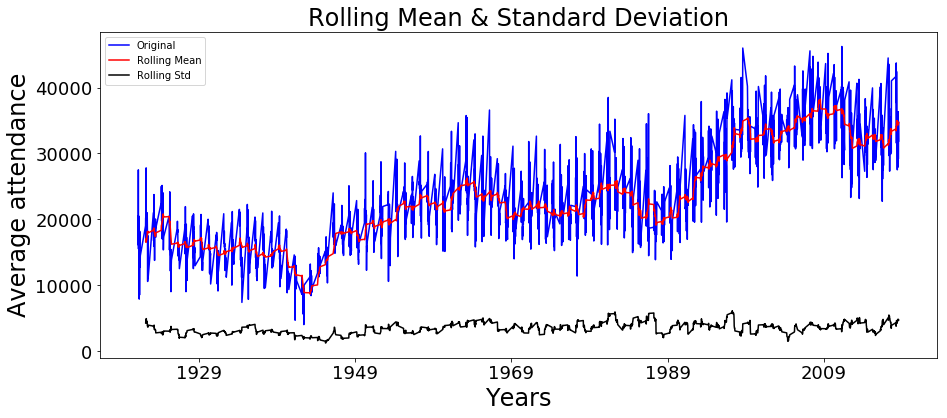

In [7]:
test_stationarity(tsfull,20, "Average attendance")

### As we can see the Avereage Attendance data is not stationary. Attendance mean is growing and standart deviation also varies.
#### Dickey-Fuller Test of stationarity also suppports this finding. Test Statistics Value is bigger than 5% Critical Value

<a id="problem"></a>
## 3. Problem Statement

## Historical AFL attendance data starts in 1921 and ends on Round 18 of season 2018.
## <font color='blue'>Our goal is to forecast average attenance for the remaining Rounds 19 - 23.</font>

<a id="arima"></a>
## 4. ARIMA model - AutoRegregressive Integrated Moving Average
   ### 4.1 Making Time Series Stationary and eliminating Trend and Seasonality

In [8]:
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [9]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

In [10]:
# difference data
lag = 12
stationary = difference(ts, lag)

Results of Dickey-Fuller Test:
Test Statistic                -9.225373e+00
p-value                        1.734951e-15
#Lags Used                     2.400000e+01
Number of Observations Used    1.490000e+03
Critical Value (1%)           -3.434746e+00
Critical Value (5%)           -2.863482e+00
Critical Value (10%)          -2.567804e+00
dtype: float64


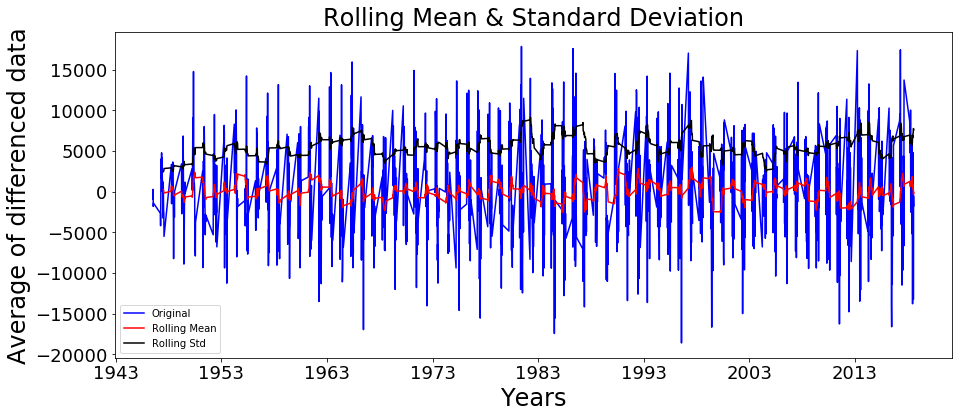

In [11]:
ts1 = pd.Series(data = stationary, index=ts[lag:].index)
test_stationarity(ts1, 20, 'Average of differenced data')

## As we can see differenced data (attandance[t] - attendance[t - 1]) is stationary.
### There are  other techniques to make time series stationary, e.g. Log transformation and Decomposition.
### Example of Decomposition on Log transfromed data

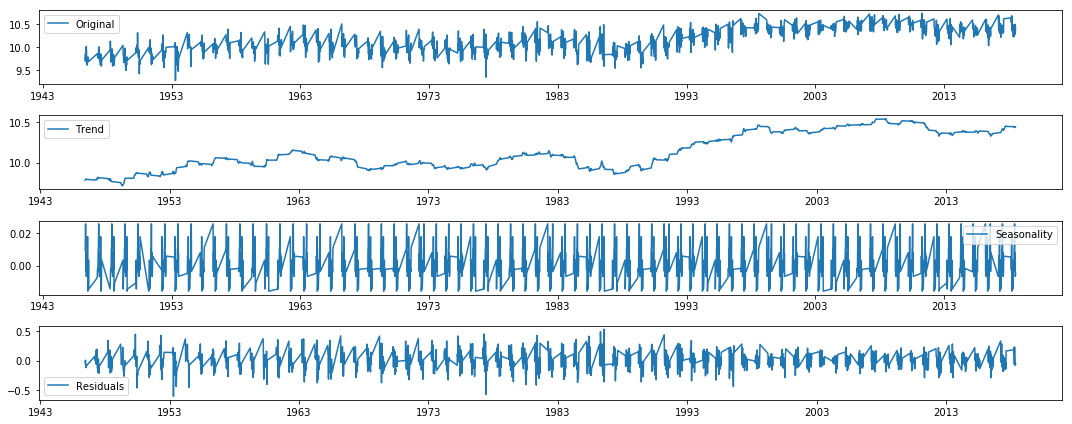

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_log = np.log(ts)
decomposition = seasonal_decompose(ts_log,freq=20)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## 4.2 Training ARIMA model

In [13]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [14]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.7)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):
        # difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        # predict
        model = ARIMA(diff, order=(4,1,1))
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = -47.9 + inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        # observation
        obs = test[i]
        history.append(obs)
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    
    residuals = [test[i]-predictions[i] for i in range(len(test))]
    residuals = pd.DataFrame(residuals)
    result = [rmse, residuals, predictions]
    return result

In [15]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    #return best_cfg, best_score

In [16]:
# load dataset
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)

In [17]:
#%%time
#evaluate_models(ts, p_values, d_values, q_values)
# !!! Greed Search TAKES > ONE HOUR !!!

In [18]:
arima_order = (4,1,1)

In [19]:
%%time
res = evaluate_arima_model(ts,arima_order)

/Users/igorshvab/Documents/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 5min 19s, sys: 6.59 s, total: 5min 26s
Wall time: 5min 20s


In [20]:
residuals = res[1]
residuals.describe()

,0
count,459.000000
mean,-75.736198
std,5611.116585
min,-16366.591709
25%,-3501.309851
50%,-141.280003
75%,3459.761029
max,18645.357407


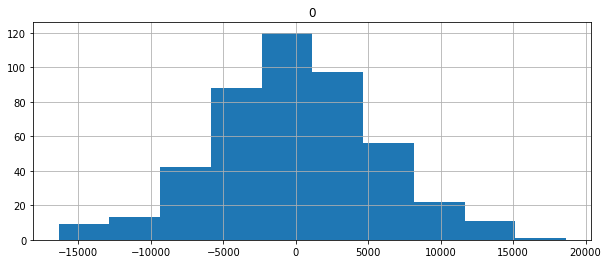

In [21]:
# plot residuals
rcParams['figure.figsize'] = 10,4
residuals.hist(ax=plt.gca())
bias = residuals.describe().iloc[1,]

### Mean residual error is nonzero so in all further calculations I am going to add it to my predictions as bias correction

## 4.3 Save ARIMA model

In [22]:
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
 
ARIMA.__getnewargs__ = __getnewargs__

In [23]:
lag = 12
diff = difference(ts, lag)
model = ARIMA(diff, order=arima_order)
model_fit = model.fit(trend='nc', disp=0)
# save model
model_fit.save('model.pkl')
np.save('model_bias.npy', [bias])

/Users/igorshvab/Documents/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [24]:
from statsmodels.tsa.arima_model import ARIMAResults
model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])

## 4.4 Fit ARIMA model

In [25]:
history = [x for x in ts]
lag = 12
pos = int(len(ts)*0.7)
validation = ts[pos:]
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, lag)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

# rolling forecasts
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, lag)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
    # difference data
    months_in_year = 12
    diff = difference(history, lag)
    # predict
    model = ARIMA(diff, order=arima_order)
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, lag)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Season %d %s: Predicted=%.3f, Actual=%3.f' % (data.Date.iloc[pos+450+i,].year, data.Round.iloc[pos+450+i,], yhat, obs))
# report performance
tmp = []
for i in predictions:
    tmp.append(i[0][0])
mse = mean_squared_error(y, np.array(tmp))
rmse = sqrt(mse)
print('\033[1m' "Test RMSE: %.3f" '\033[0;0m' % rmse)

>Predicted=29497.310, Expected=29432
>Predicted=30749.310, Expected=29432
>Season 1998 Round 10: Predicted=26812.391, Actual=31915
>Season 1998 Round 11: Predicted=35430.930, Actual=41526
>Season 1998 Round 12: Predicted=35260.908, Actual=32386
>Season 1998 Round 13: Predicted=28825.306, Actual=30216
>Season 1998 Round 14: Predicted=32921.162, Actual=33157
>Season 1998 Round 15: Predicted=33179.568, Actual=35120
>Season 1998 Round 16: Predicted=36799.098, Actual=36872
>Season 1998 Round 17: Predicted=29777.922, Actual=30713
>Season 1998 Round 18: Predicted=35356.869, Actual=34736
>Season 1998 Round 19: Predicted=32260.440, Actual=33504
>Season 1998 Round 20: Predicted=29767.073, Actual=32789
>Season 1998 Round 21: Predicted=29963.716, Actual=40983
>Season 1998 Round 22: Predicted=33399.883, Actual=45997
>Season 1999 Round 1: Predicted=44622.568, Actual=40208
>Season 1999 Round 2: Predicted=35775.246, Actual=38275
>Season 1999 Round 3: Predicted=32974.202, Actual=32045
>Season 1999 Roun

/Users/igorshvab/Documents/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Season 2001 Round 3: Predicted=35098.548, Actual=35477
>Season 2001 Round 4: Predicted=35683.289, Actual=33804
>Season 2001 Round 5: Predicted=30409.882, Actual=36084
>Season 2001 Round 6: Predicted=32277.217, Actual=33678
>Season 2001 Round 7: Predicted=35383.964, Actual=37534
>Season 2001 Round 8: Predicted=26305.664, Actual=26226
>Season 2001 Round 9: Predicted=31640.292, Actual=33613
>Season 2001 Round 10: Predicted=37790.502, Actual=31270
>Season 2001 Round 11: Predicted=38493.591, Actual=40345
>Season 2001 Round 12: Predicted=40091.600, Actual=32009
>Season 2001 Round 13: Predicted=34566.083, Actual=29567
>Season 2001 Round 14: Predicted=29718.940, Actual=34929
>Season 2001 Round 15: Predicted=34080.289, Actual=31771
>Season 2001 Round 16: Predicted=32795.207, Actual=35917
>Season 2001 Round 17: Predicted=35927.881, Actual=30240
>Season 2001 Round 18: Predicted=33205.014, Actual=41780
>Season 2001 Round 19: Predicted=37469.615, Actual=34071
>Season 2001 Round 20: Predicted=26389

/Users/igorshvab/Documents/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Season 2002 Round 7: Predicted=30098.814, Actual=35044
>Season 2002 Round 8: Predicted=41812.899, Actual=26769
>Season 2002 Round 9: Predicted=33274.411, Actual=31327
>Season 2002 Round 10: Predicted=29588.162, Actual=30348
>Season 2002 Round 11: Predicted=31705.127, Actual=35745
>Season 2002 Round 12: Predicted=28505.818, Actual=25881
>Season 2002 Round 13: Predicted=36603.230, Actual=31636
>Season 2002 Round 14: Predicted=31252.026, Actual=30635
>Season 2002 Round 15: Predicted=32694.801, Actual=32129
>Season 2002 Round 16: Predicted=26625.112, Actual=35725
>Season 2002 Round 17: Predicted=39160.608, Actual=29674
>Season 2002 Round 18: Predicted=29525.263, Actual=28380
>Season 2002 Round 19: Predicted=34502.727, Actual=29384
>Season 2002 Round 20: Predicted=25512.808, Actual=35020
>Season 2002 Round 21: Predicted=30412.246, Actual=32573
>Season 2002 Round 22: Predicted=30810.444, Actual=35797
>Season 2003 Round 1: Predicted=36917.926, Actual=38345
>Season 2003 Round 2: Predicted=274

/Users/igorshvab/Documents/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Season 2003 Round 13: Predicted=38750.099, Actual=31332
>Season 2003 Round 14: Predicted=29177.053, Actual=35286
>Season 2003 Round 15: Predicted=28842.980, Actual=32129
>Season 2003 Round 16: Predicted=32177.679, Actual=34024
>Season 2003 Round 17: Predicted=40110.865, Actual=33799
>Season 2003 Round 18: Predicted=29610.849, Actual=32120
>Season 2003 Round 19: Predicted=32236.583, Actual=35594
>Season 2003 Round 20: Predicted=31954.460, Actual=31694
>Season 2003 Round 21: Predicted=31675.060, Actual=35927
>Season 2003 Round 22: Predicted=31309.769, Actual=35391
>Season 2004 Round 1: Predicted=40911.883, Actual=32963
>Season 2004 Round 2: Predicted=34529.640, Actual=35111
>Season 2004 Round 3: Predicted=31394.540, Actual=32827
>Season 2004 Round 4: Predicted=35045.990, Actual=33560
>Season 2004 Round 5: Predicted=31947.040, Actual=33624
>Season 2004 Round 6: Predicted=34152.534, Actual=33373
>Season 2004 Round 7: Predicted=33833.231, Actual=35835
>Season 2004 Round 8: Predicted=32240.

/Users/igorshvab/Documents/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Season 2009 Round 17: Predicted=31913.196, Actual=45181
>Season 2009 Round 18: Predicted=40142.469, Actual=31592
>Season 2009 Round 19: Predicted=31662.594, Actual=32886
>Season 2009 Round 20: Predicted=37922.687, Actual=35467
>Season 2009 Round 21: Predicted=37914.522, Actual=37805
>Season 2009 Round 22: Predicted=29734.027, Actual=38555
>Season 2010 Round 1: Predicted=37813.368, Actual=42139
>Season 2010 Round 2: Predicted=33211.035, Actual=39737
>Season 2010 Round 3: Predicted=41058.026, Actual=36102
>Season 2010 Round 4: Predicted=37000.812, Actual=37448
>Season 2010 Round 5: Predicted=34327.003, Actual=41355
>Season 2010 Round 6: Predicted=36203.111, Actual=43478
>Season 2010 Round 7: Predicted=46909.195, Actual=36378
>Season 2010 Round 8: Predicted=33375.740, Actual=30703
>Season 2010 Round 9: Predicted=33087.800, Actual=41566
>Season 2010 Round 10: Predicted=35212.352, Actual=31442
>Season 2010 Round 11: Predicted=38159.620, Actual=32815
>Season 2010 Round 12: Predicted=38779.9

>Season 2016 Round 2: Predicted=35107.137, Actual=39348
>Season 2016 Round 3: Predicted=34271.655, Actual=33297
>Season 2016 Round 4: Predicted=30194.594, Actual=30956
>Season 2016 Round 5: Predicted=34491.475, Actual=40610


/Users/igorshvab/Documents/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>Season 2016 Round 6: Predicted=30249.705, Actual=31395
>Season 2016 Round 7: Predicted=34901.678, Actual=32497
>Season 2016 Round 8: Predicted=29997.727, Actual=29704
>Season 2016 Round 9: Predicted=33345.889, Actual=32882
>Season 2016 Round 10: Predicted=32893.520, Actual=33612
>Season 2016 Round 11: Predicted=29013.726, Actual=27356
>Season 2016 Round 12: Predicted=29469.537, Actual=35808
>Season 2016 Round 13: Predicted=40338.072, Actual=26262
>Season 2016 Round 14: Predicted=39308.154, Actual=22719
>Season 2016 Round 15: Predicted=31777.850, Actual=33952
>Season 2016 Round 16: Predicted=27841.770, Actual=26113
>Season 2016 Round 17: Predicted=37015.816, Actual=29228
>Season 2016 Round 18: Predicted=29021.835, Actual=30334
>Season 2016 Round 19: Predicted=30590.108, Actual=27446
>Season 2016 Round 20: Predicted=27335.991, Actual=33867
>Season 2016 Round 21: Predicted=31407.021, Actual=30264
>Season 2016 Round 22: Predicted=33121.360, Actual=28172
>Season 2016 Round 23: Predicted=26

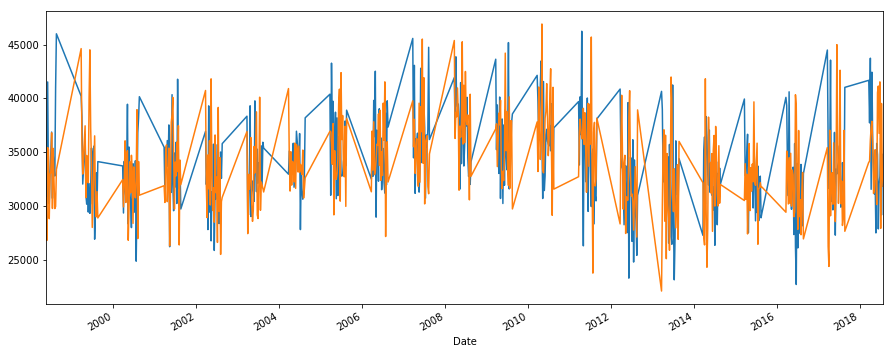

In [26]:
p = pd.Series(np.array(tmp),index=ts[pos:].index)
r = pd.Series(y,index=ts[pos:].index)
r.plot(figsize=(15,6))
p.plot()

<a id="lstm"></a>
## 5. LSTM - Long Short-Term Memory neural network.
### Application for Time Series analysis

In [27]:
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

Using TensorFlow backend.


In [28]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference_(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference_(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [29]:
# transform data to be stationary
series = ts
raw_values = series.values
diff_values = difference_(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[:pos], supervised_values[pos:]

In [30]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 50, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
pos = int(0.7*len(series))
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Season %d, %s, Predicted=%f, Actual=%f' % (data.Date.iloc[i+450+pos,].year, data.Round.iloc[i+450+pos,], yhat, expected))

Season 1998, Round 9, Predicted=34665.596912, Actual=31915.000000
Season 1998, Round 10, Predicted=34535.020532, Actual=41526.000000
Season 1998, Round 11, Predicted=35411.567466, Actual=32386.000000
Season 1998, Round 12, Predicted=35661.895898, Actual=30216.000000
Season 1998, Round 13, Predicted=34051.571530, Actual=33157.000000
Season 1998, Round 14, Predicted=34442.605363, Actual=35120.000000
Season 1998, Round 15, Predicted=35256.066357, Actual=36872.000000
Season 1998, Round 16, Predicted=36192.503364, Actual=30713.000000
Season 1998, Round 17, Predicted=35021.059465, Actual=34736.000000
Season 1998, Round 18, Predicted=35263.930423, Actual=33504.000000
Season 1998, Round 19, Predicted=35715.804603, Actual=32789.000000
Season 1998, Round 20, Predicted=35577.557605, Actual=40983.000000
Season 1998, Round 21, Predicted=36342.026366, Actual=45997.000000
Season 1998, Round 22, Predicted=37791.502956, Actual=40208.000000
Season 1999, Round 1, Predicted=39796.650715, Actual=38275.0000

Season 2005, Round 9, Predicted=36072.852662, Actual=38187.000000
Season 2005, Round 10, Predicted=36593.854738, Actual=30979.000000
Season 2005, Round 11, Predicted=35588.133545, Actual=36457.000000
Season 2005, Round 12, Predicted=35911.004508, Actual=32948.000000
Season 2005, Round 13, Predicted=36051.731890, Actual=37798.000000
Season 2005, Round 14, Predicted=36594.254364, Actual=32879.000000
Season 2005, Round 15, Predicted=36407.279246, Actual=32781.000000
Season 2005, Round 16, Predicted=35875.276854, Actual=32910.000000
Season 2005, Round 17, Predicted=35890.269434, Actual=34111.000000
Season 2005, Round 18, Predicted=36241.654184, Actual=34618.000000
Season 2005, Round 19, Predicted=36680.383173, Actual=37897.000000
Season 2005, Round 20, Predicted=37517.083151, Actual=33751.000000
Season 2005, Round 21, Predicted=37302.194936, Actual=38905.000000
Season 2005, Round 22, Predicted=37870.756475, Actual=32508.000000
Season 2006, Round 1, Predicted=36946.697050, Actual=35128.0000

Season 2012, Round 8, Predicted=34673.100457, Actual=30364.000000
Season 2012, Round 9, Predicted=34267.538393, Actual=27535.000000
Season 2012, Round 10, Predicted=32652.046310, Actual=39607.000000
Season 2012, Round 11, Predicted=33910.925470, Actual=23309.000000
Season 2012, Round 12, Predicted=29115.536042, Actual=30668.000000
Season 2012, Round 13, Predicted=29005.081019, Actual=34521.000000
Season 2012, Round 14, Predicted=30040.909247, Actual=34403.000000
Season 2012, Round 15, Predicted=31621.244883, Actual=26726.000000
Season 2012, Round 16, Predicted=30428.087817, Actual=36157.000000
Season 2012, Round 17, Predicted=30695.713915, Actual=24803.000000
Season 2012, Round 18, Predicted=29179.876260, Actual=34281.000000
Season 2012, Round 19, Predicted=29285.653051, Actual=29795.000000
Season 2012, Round 20, Predicted=30558.262248, Actual=28660.000000
Season 2012, Round 21, Predicted=30349.535571, Actual=25422.000000
Season 2012, Round 22, Predicted=29353.013298, Actual=30998.0000

In [31]:
data.tail()

,Date,Round,Total,Games,Ave.
14,2018-06-28,Round 15,295018,9,32780
15,2018-07-05,Round 16,326995,9,36333
16,2018-07-12,Round 17,262516,9,29168
17,2018-07-19,Round 18,313343,9,34816
18,2018-07-26,Round 19,286798,9,31866


In [32]:
# report performance
rmse = sqrt(mean_squared_error(series[int(0.7*len(series))+1:].values, predictions))
print('\033[1m' "Test RMSE: %.3f" '\033[0;0m' % rmse)

Test RMSE: 4180.948


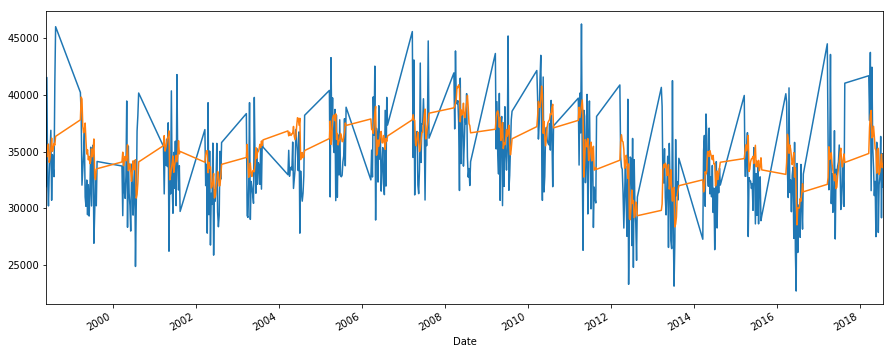

In [33]:
p = pd.Series(predictions, index=series[pos+1:].index)
r = pd.Series(series[int(0.7*len(series))+1:].values, index=series[pos+1:].index)
r.plot(figsize=(15,6))
p.plot()

<a id="prediction"></a>
# <font color='blue'>6. Average attendance forecast for Rounds 19 - 22 of season 2018</font>

In [35]:
lag = 12
differenced = difference(ts, lag)
# fit model
model = ARIMA(differenced, order=arima_order)
model_fit = model.fit(disp=0)
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=4)[0]
# invert the differenced forecast to something usable
history = [x for x in ts]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, lag)
    print("\033[1m" 'Season 2018 Round %d: %f' "\033[0;0m" % (day + 18, inverted))
    history.append(inverted)
    day += 1

Season 2018 Round 19: 29535.973498
Season 2018 Round 20: 31238.014098
Season 2018 Round 21: 26996.278390
Season 2018 Round 22: 35360.024724
